In [1]:
import os
import matplotlib.pyplot as plt

import rasterio as rio
import cartopy.crs as ccrs

from subprocess import Popen

import numpy as np

import json
from shapely.geometry import shape

%matplotlib inline

In [2]:
import seaborn as sns

In [3]:
sturm = "/Users/tony/Downloads/snowclass_030arcsec.txt"

In [4]:
sturm_classes = {
    "Water" : 0,
    "Tundra" : 1,
    "Taiga" : 2,
    "Maritime" : 3,
    "Ephemeral" : 4,
    "Prairie" : 5,
    "Warm Forest" : 6,
    "Ice" : 7
}
sturm_ids = {
    v : k for k, v in sturm_classes.items()
}

In [5]:
sturm_ids

{0: 'Water',
 1: 'Tundra',
 2: 'Taiga',
 3: 'Maritime',
 4: 'Ephemeral',
 5: 'Prairie',
 6: 'Warm Forest',
 7: 'Ice'}

In [13]:
# tuolumne = "/Volumes/wrangell-st-elias/research/planet/tuo-head-4326.geojson"
tuolumne = "/Users/tony/Downloads/USCATE_footprints.geojson"
colorado = "/Users/tony/Downloads/co-watershed.geojson"

In [14]:
clip_cmd = "source activate qgis; gdalwarp -cutline {cutline} -s_srs EPSG:4326 -crop_to_cutline {sturm} $(dirname {sturm})/$(basename {sturm} .txt)_{loc}_clip.tif"

In [15]:
cmd = clip_cmd.format(cutline = tuolumne, sturm = sturm, loc='tuolumne2')
print(cmd)
Popen(cmd, shell=True).communicate()

source activate qgis; gdalwarp -cutline /Users/tony/Downloads/USCATE_footprints.geojson -s_srs EPSG:4326 -crop_to_cutline /Users/tony/Downloads/snowclass_030arcsec.txt $(dirname /Users/tony/Downloads/snowclass_030arcsec.txt)/$(basename /Users/tony/Downloads/snowclass_030arcsec.txt .txt)_tuolumne2_clip.tif


(None, None)

In [16]:
cmd = clip_cmd.format(cutline = colorado, sturm = sturm, loc='colorado')
print(cmd)
Popen(cmd, shell=True).communicate()

source activate qgis; gdalwarp -cutline /Users/tony/Downloads/co-watershed.geojson -s_srs EPSG:4326 -crop_to_cutline /Users/tony/Downloads/snowclass_030arcsec.txt $(dirname /Users/tony/Downloads/snowclass_030arcsec.txt)/$(basename /Users/tony/Downloads/snowclass_030arcsec.txt .txt)_colorado_clip.tif


(None, None)

In [23]:
sturm_tuol = rio.open(os.path.join(os.path.dirname(sturm), os.path.splitext(sturm)[0]+"_tuolumne2_clip.tif"))

In [24]:
sturm_colo = rio.open(os.path.join(os.path.dirname(sturm), os.path.splitext(sturm)[0]+"_colorado_clip.tif"))


In [25]:
sturm_colo_data = sturm_colo.read(1)
sturm_colo_data = sturm_colo_data[~(sturm_colo_data == -9999) & (sturm_colo_data > 0)].flatten()
sturm_tuol_data = sturm_tuol.read(1)
sturm_tuol_data = sturm_tuol_data[~(sturm_tuol_data == -9999) & (sturm_tuol_data > 0)].flatten()

(array([3.50e+01, 6.17e+02, 0.00e+00, 1.58e+02, 0.00e+00, 4.53e+02,
        1.00e+00, 0.00e+00, 7.17e+02, 1.29e+03]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ],
       dtype=float32),
 <a list of 10 Patch objects>)

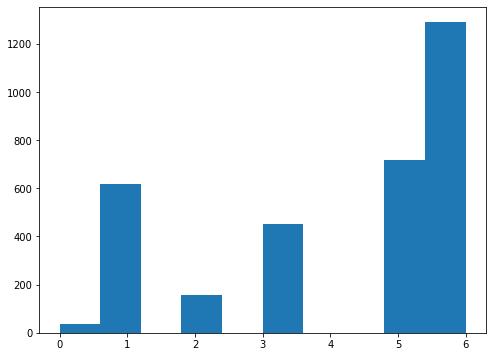

In [26]:
from matplotlib.ticker import FuncFormatter, MaxNLocator

fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.hist(sturm_tuol.read(masked=True).flatten())
# ax.xaxis.set_major_formatter(FuncFormatter(format_sturm))
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))

[Text(0, 0, 'Water'),
 Text(0, 0, 'Tundra'),
 Text(0, 0, 'Taiga'),
 Text(0, 0, 'Maritime'),
 Text(0, 0, 'Ephemeral'),
 Text(0, 0, 'Prairie'),
 Text(0, 0, 'Warm Forest')]

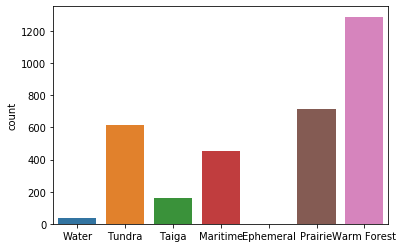

In [27]:
fig, ax = plt.subplots()
sturm_tuol_data = sturm_tuol.read(1)
sturm_tuol_data = sturm_tuol_data[~(sturm_tuol_data == -9999)].flatten()
sns.countplot(sturm_tuol_data, ax=ax, )
labels = [sturm_ids[int(float(i.get_text()))] for i in ax.get_xticklabels()]
ax.set_xticklabels(labels)
# ax.xaxis.set_major_formatter(FuncFormatter(format_sturm))
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))

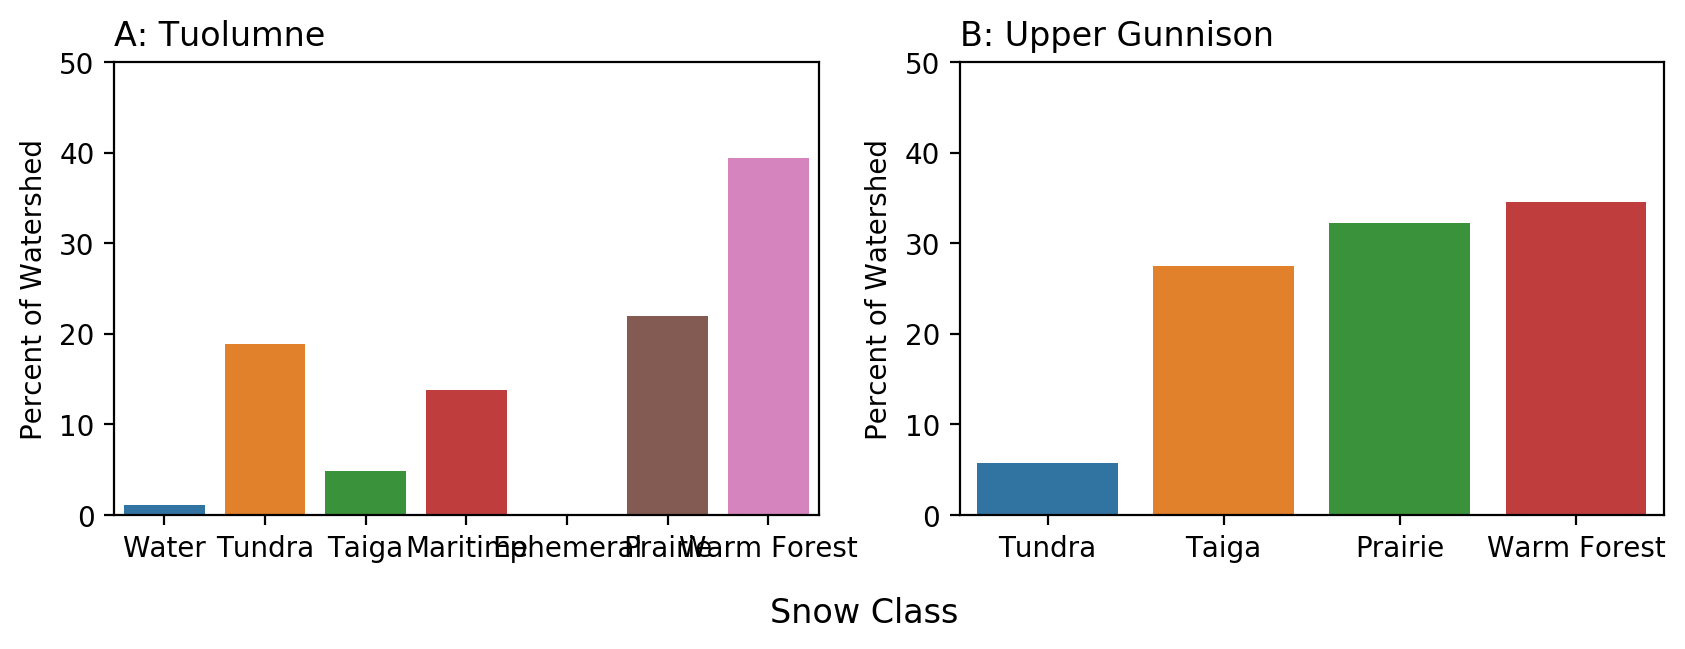

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), dpi=200)
fig.suptitle('Snow Class', y=-0.01)

ylim = [0, 50]

ax_tuol = axes[0]
sns.barplot(x=sturm_tuol_data, y=sturm_tuol_data, estimator=lambda x: len(x) / len(sturm_tuol_data) * 100, ax=ax_tuol)
labels = [sturm_ids[int(float(i.get_text()))] for i in ax_tuol.get_xticklabels()]
ax_tuol.set_xticklabels(labels)
ax_tuol.set_ylabel("Percent of Watershed")
ax_tuol.set_title("A: Tuolumne", loc='left')
ax_tuol.set_ylim(ylim)

ax_colo = axes[1]
sns.barplot(x=sturm_colo_data, y=sturm_colo_data, estimator=lambda x: len(x) / len(sturm_colo_data) * 100, ax=ax_colo)
labels = [sturm_ids[int(float(i.get_text()))] for i in ax_colo.get_xticklabels()]
ax_colo.set_xticklabels(labels)
ax_colo.set_ylabel("Percent of Watershed")
ax_colo.set_title("B: Upper Gunnison", loc='left')
ax_colo.set_ylim(ylim)

plt.savefig("snowclass_comparison.png", dpi=300, bbox_inches='tight')